# Whale Tail Bounding Box Detection
In this part of the project I will use PyTorch in order to construct a bounding box detector network. For this part of the project I will start by watching the Fast.ai video on object detection and localization (http://course.fast.ai/lessons/lesson8.html) and then attempt to use their notebook to construct a network that can perform bounding box detection for my labelled dataset. Once we have a network that is doing a good job of generating bounding boxes we will move on to the next step of the project which will involve labelling fluke/notch points on the whale’s tail


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

import pandas as pd

## Data Exploration
Let's visually inspect our dataset and make sure that the bounding box labels we have make sense

In [3]:
PATH = Path('/home/ubuntu/data/whale-categorization-playground')
list(PATH.iterdir())

[PosixPath('/home/ubuntu/data/whale-categorization-playground/train'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/bb-train'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/tmp'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/sample_submission.csv'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/bb_kaggle.csv'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train.csv'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/models'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/test.zip')]

In [4]:
IMG_PATH = PATH/"train"
list(IMG_PATH.iterdir())[:5]

[PosixPath('/home/ubuntu/data/whale-categorization-playground/train/beba228a.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/6c5ad43e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/974961a4.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/d9f3391e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/f1ca32dc.jpg')]

In [5]:
test_image = list(IMG_PATH.iterdir())[:5][0]
im = open_image(test_image)

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

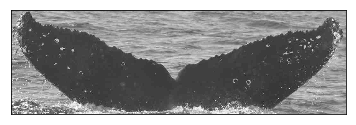

In [7]:
show_img(im)

In [8]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

## Extract Bounding Boxes
We are using a file names bb_kaggle.csv in order to fetch our bounding box labels. Let's try to load this data.

In [9]:
bb_df = pd.read_csv(PATH/"bb_kaggle.csv")

In [10]:
bb_df.head(2)

,fn,bbox
0,097f138b.jpg,20 3 423 1042
1,c85f1d58.jpg,14 25 547 1009


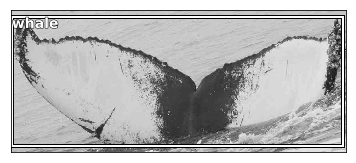

In [11]:
im = open_image(PATH/"train"/bb_df.head(1).iloc[0]['fn'])
ax = show_img(im)
b = bb_hw([20, 3, 423, 1042])
draw_rect(ax, b)
draw_text(ax, b[:2], 'whale')

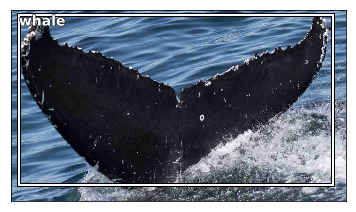

In [12]:
im = open_image(PATH/"train"/bb_df.head(2).iloc[1]['fn'])
ax = show_img(im)
b = bb_hw([14, 25, 547, 1009])
draw_rect(ax, b)
draw_text(ax, b[:2], 'whale')

## Build our model
Now that we feel relativley confident that the labels we have in our file are correct we can move on to building our model. We will base our model off of Resnet34 and modify the final layer of the network to add 4 activations which correspond to our x,y,w,h of our bounding box.

In [13]:
BB_CSV = PATH/'bb_kaggle.csv'
JPEGS = 'bb-train'

In [14]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '097f138b.jpg,20 3 423 1042\n',
 'c85f1d58.jpg,14 25 547 1009\n',
 '0739fcdc.jpg,48 37 304 1020\n',
 '12440f36.jpg,75 34 516 1019\n']

### Define our model

In [15]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [16]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(10, tfm_y=TfmType.COORD),
        RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]

In [17]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=32)

[  7.   0. 209. 204.]
[  8.  21. 207. 159.]
[  7.   0. 209. 206.]
[  7.   0. 209. 201.]
[ 10.  21. 206. 159.]
[  6.   0. 212. 223.]
[ 10.  21. 206. 159.]
[  7.   0. 211. 223.]
[  8.   0. 210. 216.]


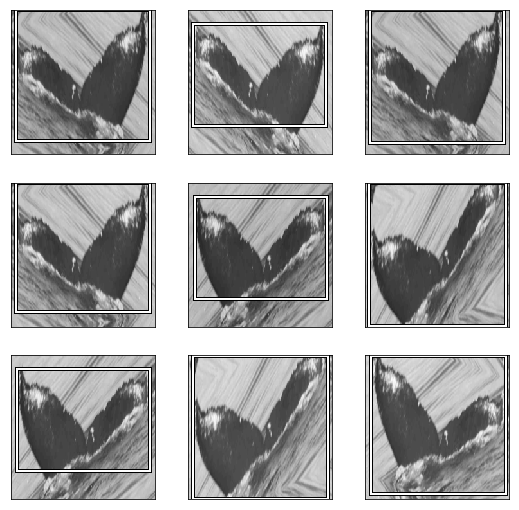

In [18]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [22]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [23]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 15/17 [00:02<00:00,  5.25it/s, loss=614]


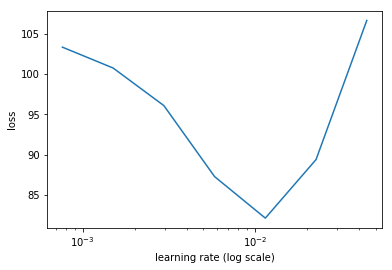

In [30]:
learn.lr_find(1e-4,10)
learn.sched.plot(3)

In [31]:
lr = 1e-2

In [32]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      63.960473  39.418949 
    1      78.21237   54.008505                           
    2      55.747532  18.174524                           



[array([18.17452])]

In [33]:
lrs = np.array([lr/100,lr/10,lr])

In [34]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      100.419414 1.4835382283721748e+18



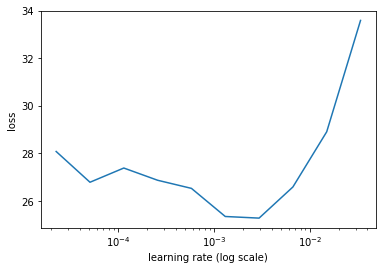

In [35]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [36]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      39.1062    24.092111 
    1      34.608785  23.221144                           
    2      25.583461  12.134336                           



[array([12.13434])]

In [37]:
learn.freeze_to(-3)

In [38]:
learn.fit(lrs, 2, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      31.013322  49.585191 
    1      21.850451  10.774183                           
    2      17.465592  9.770377                            
    3      17.081558  14.310788                           
    4      15.918405  9.288081                            
    5      13.835129  8.375831                            



[array([8.37583])]

In [39]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))
print(preds)

[[ 13.62101   4.02629 180.38521 209.67957]
 [ 66.59093  36.74541 133.52602 188.77849]
 [  5.05246   3.02937 194.50786 207.12329]
 [  3.43874   3.40652 201.47234 207.54999]
 [ 11.84509   1.44024  97.9482  213.39514]
 [ 39.03799  20.46455 156.1883  202.24916]
 [ -3.30191   0.68177 204.966   220.35251]
 [  2.89384  11.5477  200.5121  207.2996 ]
 [ 39.31294   9.21219 142.05402 207.89374]
 [ 66.02757   9.01107 125.64357 205.77914]
 [ 66.8504   21.00042 161.05821 200.26088]
 [ 40.45882   5.67721 145.8748  215.7656 ]
 [  7.50258   2.79988 214.82733 224.06898]
 [ 45.53522   1.01321 173.74919 215.0182 ]
 [ 20.97857   2.7045  188.56607 209.32472]
 [ 56.18656  13.91402 153.44142 203.89357]
 [  7.20793   3.51874 203.76503 216.3875 ]
 [  1.10482   1.31749 204.09274 216.02531]
 [ 30.34153   9.56738 166.4439  205.25272]
 [  3.84265   2.08614 213.88455 215.89494]
 [ 12.46202   3.11519 203.97722 214.20863]
 [ 15.47683   1.57314 195.25685 209.7991 ]
 [ -3.17968   9.64333 191.17552 203.1866 ]
 [ 28.52975

In [41]:
learn.save('reg4')

In [132]:
learn.load('reg4')

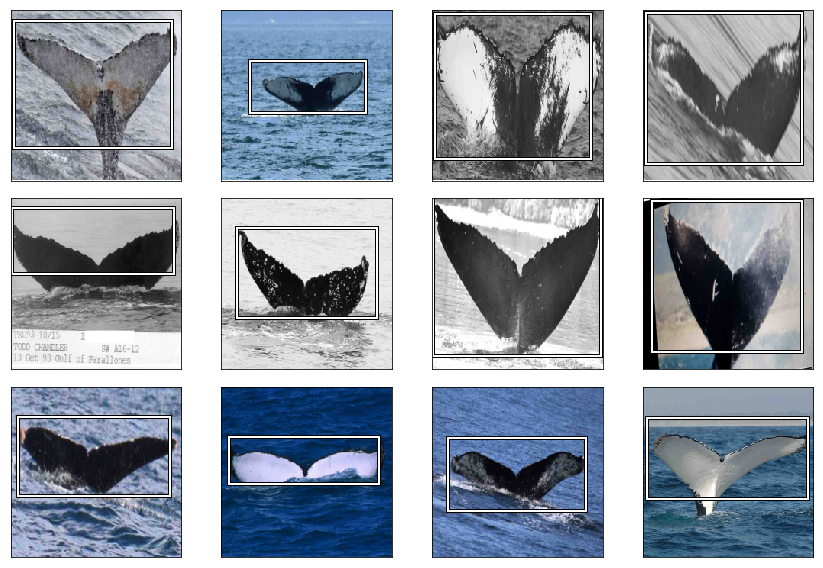

In [40]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

# Apply model to images
Let's build a new training set using our constructed model that crops all of our existing test images and places the new results in a cropped-train directory.

In [42]:
train_images = list(IMG_PATH.iterdir())
train_images[:4]

[PosixPath('/home/ubuntu/data/whale-categorization-playground/train/beba228a.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/6c5ad43e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/974961a4.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/train/d9f3391e.jpg')]

(600, 1050, 3)


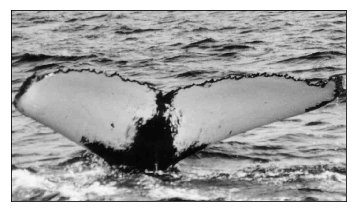

In [43]:
i = train_images[2]
im = open_image(i)
print(im.shape)
show_img(im)

In [44]:
trn_tfms, val_tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
im = val_tfms(open_image(i))
preds = learn.predict_array(im[None])

In [45]:
preds

array([[ 40.76381,   3.80018, 180.8609 , 213.25262]], dtype=float32)

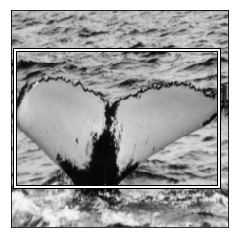

In [46]:
ima=md.val_ds.denorm(to_np(im[None]))[0]
ax = show_img(ima)
b = bb_hw(preds[0])
draw_rect(ax, b)

# TODO: Apply model to all images in folder to create modified training set